# SpamAssassin Data Preparation for Azure AI Foundry Fine-tuning

## Introduction
This notebook demonstrates how to prepare the SpamAssassin phishing email dataset for fine-tuning Small Language Models (SLMs) in Azure AI Foundry.

### Dataset Source
The original data can be downloaded from: https://github.com/rokibulroni/Phishing-Email-Dataset/blob/main/SpamAssasin.csv

### Dataset Overview
The SpamAssassin dataset is a comprehensive collection of labeled emails designed for phishing detection research. 

**Key Features:**
- **Email ID**: Unique identifier for each email
- **Sender**: Email address of the sender
- **Recipient**: Email address of the recipient
- **Subject**: Subject line of the email
- **Body**: Main content of the email
- **Timestamp**: Date and time when the email was sent
- **Attachments**: List of any attachments included
- **URL Links**: Extracted URLs from the email body
- **Labels**: Binary classification (phishing/legitimate)

**Why This Dataset?**
Phishing attacks remain one of the most prevalent cybersecurity threats, targeting individuals and organizations to steal sensitive information, credentials, or financial data. This dataset provides a rich source of labeled emails to facilitate the development of effective phishing detection systems.

## Step 0: Install Required Packages

Before we begin, let's ensure all required packages are installed.

```powershell
pip install pandas
pip install numpy
pip install requests
pip install openai
pip install scikit-learn
pip install matplotlib
pip install seaborn
```

## Step 1: Import Required Libraries

In [1]:
import pandas as pd
import json
import requests
import os
from typing import Dict, Any, Optional
import numpy as np
from openai import AzureOpenAI
import copy
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Download and Load the Dataset

In [2]:
# Download the dataset from GitHub
url = "https://raw.githubusercontent.com/rokibulroni/Phishing-Email-Dataset/main/SpamAssasin.csv"
dataset_path = "SpamAssasin.csv"

# Download if not already present
if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    response = requests.get(url)
    with open(dataset_path, 'wb') as f:
        f.write(response.content)
    print("Dataset downloaded successfully!")
else:
    print("Dataset already exists locally.")

# Load the dataset
df = pd.read_csv(dataset_path)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset already exists locally.
Dataset loaded: 5809 rows, 7 columns


## Step 3: Basic Data Profiling

In [3]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\n" + "="*50 + "\n")

# Display first few rows
print("Sample Data:")
print(df.head())
print("\n" + "="*50 + "\n")

# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50 + "\n")

# Label distribution
print("Label Distribution:")
label_counts = df.label.value_counts()
print(label_counts)
print(f"\nPercentage distribution:")
print(f"Legitimate (0): {label_counts[0]/len(df)*100:.2f}%")
print(f"Phishing (1): {label_counts[1]/len(df)*100:.2f}%")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5809 entries, 0 to 5808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    5809 non-null   object
 1   receiver  5599 non-null   object
 2   date      5809 non-null   object
 3   subject   5793 non-null   object
 4   body      5808 non-null   object
 5   label     5809 non-null   int64 
 6   urls      5809 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 317.8+ KB
None


Sample Data:
                                      sender  \
0             Robert Elz <kre@munnari.OZ.AU>   
1  Steve Burt <Steve_Burt@cursor-system.com>   
2              "Tim Chapman" <timc@2ubh.com>   
3           Monty Solomon <monty@roscom.com>   
4  Stewart Smith <Stewart.Smith@ee.ed.ac.uk>   

                                            receiver  \
0  Chris Garrigues <cwg-dated-1030377287.06fa6d@D...   
1  "'zzzzteana@yahoogroups.com'" <zzzzteana@yahoo...   
2        

In [4]:
# Sample emails from each class
print("Sample Legitimate Email:")
print("="*50)
print(df[df['label'] == 0].iloc[0]['body'][:500] + "...")
print("\n" + "="*50 + "\n")
print("Sample Phishing Email:")
print("="*50)
print(df[df['label'] == 1].iloc[0]['body'][:500] + "...")

Sample Legitimate Email:
Date:        Wed, 21 Aug 2002 10:54:46 -0500     From:        Chris Garrigues      Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>   | I can't reproduce this error. For me it is very repeatable... (like every time, without fail). This is the debug log of the pick happening ... 18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury} 18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence ...


Sample Phishing Email:
* * *      ---      * * *         <= /TR> Save up to 70% on Life Insurance. Why Spend More Than You Have To? Life Quote Savings __**   _**__ **Ensurin= g your family's financial security is very important. Life Quote Savings ma= kes buying life insurance simple and affordable. We Provide FREE Access = to The Very Best Companies and The Lowest Rates.**   ---   | **Life Quote Savings** is FAST, EAS= Y and SAVES you money! Let us help you get st

## Step 4: Data Preparation for Azure AI Foundry

### Understanding Azure AI Foundry Format Requirements
Azure AI Foundry requires data in JSONL (JSON Lines) format with specific structure:
- **File Format**: JSONL (one JSON object per line)
- **Mandatory Key**: `messages`
- **Message Structure**: Each message must contain role-based conversations:
  - `system`: Sets the behavior and context for the model
  - `user`: The input prompt or question
  - `assistant`: The expected response or classification
 
Sample Azure Format:
```json{
  "messages": [
    {
      "role": "system",
      "content": "You are an email classification system. Analyze the provided email and classify it as 'legitimate' or 'phishing' based on the content. Respond with only the classification label."
    },
    {
      "role": "user",
      "content": "From: Axel Thimm <Axel.Thimm@physik.fu-berlin.de>\nTo: rpm-zzzlist@freshrpms.net\nSubject: Re: Nessus?\nBody: On Mon, Oct 07, 2002 at 11:05:21PM +0200, Matthias Saou wrote: > I've put up a new Red Hat Linux 8.0 build of nessus here : > http://ftp.freshrpms.net/pub/freshrpms/testing/nessus/ >  > It's 100% untested, although the build should be ok. The new menu was > added, but some configuration files may be better with new or different > defaults. >  > Feedback is very welcome! It works very nice, would you consider upgrading it to 1.2.6 released only a few hours after your build? Thanks! On Tue, Oct 08, 2002 at 01:49:11PM +0200, Renaud Deraison wrote: > I'm pleased to announce the availability of Nessus 1.2.6, which should > be one of the last versions of Nessus 1.2.x (hopefully), as I will soon > open a new unstable tree and start to break things again :) >  > What is new in Nessus 1.2.6, in comparison to 1.2.5 : >  > * changes by Michael Slifcak (Michael.Slifcak at guardent.com) >      + Added Bugtraq cross reference in the plugins >      + Added support for BID in nessusd (this has yet to be done on >        the client side) >         > * changes by Axel Nennker (Axel.Nennker at t-systems.com) >      + fixed the xml and html outputs >      + fixed array issues in a couple of plugins >       > * changes by Michel Arboi (arboi at bigfoot.com) >      + find_service now detects services protected by TCP wrappers >        or ACL >      + find_service detects gnuserv >      + ptyexecvp() replaced by nessus_popen() (*) >       > * changes by Renaud Deraison (deraison at cvs.nessus.org) >      + Fixed a bug which may make nasl interpret backquoted strings >        (\\n and \\r) received from the network (problem noted by Pavel >        Kankovsky) >      + nmap_wrapper.nes calls _exit() instead of exit() (*) >      + Solved the lack of bpf's on Free/Open/NetBSD and MacOSX by >        sharing _one_ among all the Nessus processes. As a result, >        Nessus's ping is much more effective on these platforms >      + bugfix in plug_set_key() which would eventually make some >        scripts take too long when writing in the KB >      + Plugins of family ACT_SETTINGS are run *after* plugins of >        family ACT_SCANNERS >      + replaced the implementation of md5 which was used when >        OpenSSL is disabled by the one from RSA (the old one would >        not work on a big-endian host) >      + Fixed plugins build issues on MacOS X >      + The nessus client compiles and links against GTK+-2.0. Of >        course, it will be horrible and unstable, as the GTK team >        does not care about backward compatibility >    > (*) These two modifications solve the problems of nmap hanging under FreeBSD >  >  >  > Special thanks go to Michael Slifcak, whose work on Nessus during the > last months have been truly appreciated even if they have not always > been as underlined as they should have been. Michael, thanks again ! >  >  > AVAILABILITY: >  > Nessus 1.2.6 is available at http://www.nessus.org/posix.html --  Axel.Thimm@physik.fu-berlin.de _______________________________________________ RPM-List mailing list  http://lists.freshrpms.net/mailman/listinfo/rpm-list"
    },
    {
      "role": "assistant",
      "content": "legitimate"
    }
  ]
}gn"

    }
  ]
} 

In [5]:
# Transform data into structured format
emails = []
for _, row in df.iterrows():
    email = {
        'sender': row['sender'],
        'receiver': row['receiver'],
        'subject': row['subject'],
        'body': row['body']
    }
    label = 'phishing' if row['label'] == 1 else 'legitimate'
    emails.append({'email': email, 'label': label})

# Create a DataFrame and shuffle
processed_df = pd.DataFrame(emails)
processed_df = processed_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Processed {len(processed_df)} emails")

Processed 5809 emails


## Step 5: Train-Test Split for Fine-tuning

In [6]:
# For demonstration let's create 1000 examples for training and 200 examples for test
train_size = 1000
test_size = 200
processed_df = processed_df.sample(frac=1, random_state=42)
train_df = processed_df[:train_size]
test_df = processed_df[-test_size:]

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# Check label distribution in splits
print("\nTraining set label distribution:")
print(train_df['label'].value_counts())
print("\nTest set label distribution:")
print(test_df['label'].value_counts())

# Save raw splits
train_df.to_json('spam_train_raw.jsonl', orient='records', lines=True, force_ascii=False)
test_df.to_json('spam_test_raw.jsonl', orient='records', lines=True, force_ascii=False)

Training set size: 1000
Test set size: 200

Training set label distribution:
label
legitimate    708
phishing      292
Name: count, dtype: int64

Test set label distribution:
label
legitimate    141
phishing       59
Name: count, dtype: int64


## Step 6: Convert to Azure AI Foundry Format

In [7]:
def format_email_content(email_data: Dict[str, str], include_metadata: bool = True) -> str:
    """Format email data into a readable string for the model."""
    content_parts = []
    
    if include_metadata:
        if 'sender' in email_data:
            content_parts.append(f"From: {email_data['sender']}")
        if 'receiver' in email_data:
            content_parts.append(f"To: {email_data['receiver']}")
    
    if 'subject' in email_data:
        content_parts.append(f"Subject: {email_data['subject']}")
    
    if 'body' in email_data:
        content_parts.append(f"Body: {email_data['body']}")
    
    return "\n".join(content_parts)

def convert_to_azure_format(
    input_file: str, 
    output_file: str,
    system_prompt: Optional[str] = None,
    include_metadata: bool = True
) -> None:
    """Convert email data to Azure AI Foundry fine-tuning format."""
    
    if system_prompt is None:
        system_prompt = (
            "You are an email classification system. Analyze the provided email "
            "and classify it as 'legitimate' or 'phishing' based on the content. "
            "Respond with only the classification label."
        )
    
    with open(input_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8') as outfile:
        
        for line in infile:
            data = json.loads(line.strip())
            email_data = data['email']
            label = data['label']
            
            email_content = format_email_content(email_data, include_metadata)
            
            # Azure AI Foundry format
            training_example = {
                "messages": [
                    {
                        "role": "system",
                        "content": system_prompt
                    },
                    {
                        "role": "user", 
                        "content": email_content
                    },
                    {
                        "role": "assistant",
                        "content": label
                    }
                ]
            }
            
            outfile.write(json.dumps(training_example, ensure_ascii=False) + '\n')

# Convert training and test sets
convert_to_azure_format('spam_train_raw.jsonl', 'spam_train_azure.jsonl')
convert_to_azure_format('spam_test_raw.jsonl', 'spam_test_azure.jsonl')
print("Conversion to Azure format completed!")

Conversion to Azure format completed!


In [8]:
# Display sample converted data
with open('spam_train_azure.jsonl', 'r') as f:
    sample = json.loads(f.readline())
    print("Sample Azure Format:")
    print(json.dumps(sample, indent=2))

Sample Azure Format:
{
  "messages": [
    {
      "role": "system",
      "content": "You are an email classification system. Analyze the provided email and classify it as 'legitimate' or 'phishing' based on the content. Respond with only the classification label."
    },
    {
      "role": "user",
      "content": "From: Axel Thimm <Axel.Thimm@physik.fu-berlin.de>\nTo: rpm-zzzlist@freshrpms.net\nSubject: Re: Nessus?\nBody: On Mon, Oct 07, 2002 at 11:05:21PM +0200, Matthias Saou wrote: > I've put up a new Red Hat Linux 8.0 build of nessus here : > http://ftp.freshrpms.net/pub/freshrpms/testing/nessus/ >  > It's 100% untested, although the build should be ok. The new menu was > added, but some configuration files may be better with new or different > defaults. >  > Feedback is very welcome! It works very nice, would you consider upgrading it to 1.2.6 released only a few hours after your build? Thanks! On Tue, Oct 08, 2002 at 01:49:11PM +0200, Renaud Deraison wrote: > I'm pleased to an

In [9]:
def validate_azure_format(file_path: str) -> bool:
    """Validate that the output file is in correct Azure AI Foundry format."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line_num, line in enumerate(file, 1):
                data = json.loads(line.strip())
                
                # Check for chat completion format
                if "messages" in data:
                    if not isinstance(data["messages"], list):
                        print(f"Line {line_num}: 'messages' should be a list")
                        return False
                    
                    for msg in data["messages"]:
                        if not all(key in msg for key in ["role", "content"]):
                            print(f"Line {line_num}: Message missing 'role' or 'content'")
                            return False
                else:
                    print(f"Line {line_num}: Invalid format - missing 'messages' field")
                    return False
        
        print("Validation successful!")
        return True
        
    except Exception as e:
        print(f"Validation error: {e}")
        return False

# Validate the converted files
validate_azure_format('spam_train_azure.jsonl')
validate_azure_format('spam_test_azure.jsonl')

Validation successful!
Validation successful!


True

## Step 7: Enhancing Training Data with GPT-O3-mini Reasoning

### Why Add Reasoning Steps?
Adding chain-of-thought reasoning to training data can significantly improve model performance by:
- Teaching the model to analyze emails systematically
- Providing interpretable decision-making processes
- Improving accuracy through structured thinking

In [10]:
# Configure Azure OpenAI
endpoint = "https://yych-mddci70i-eastus.openai.azure.com/" # Use your own endpoint for o3-mini
model_name = "o3-mini"
deployment = "o3-mini"
subscription_key = os.getenv("o3-mini-key") # Use your own API key
api_version = "2024-12-01-preview"

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=subscription_key,
)

def generate_reasoning_prompt(email_content: str) -> str:
    """Generate a detailed prompt for reasoning generation."""
    return f"""You are an expert email security analyst. Analyze the provided email to determine if it's phishing or legitimate. 
Provide detailed chain-of-thought reasoning through your analysis process.

Follow this analysis framework:
1. **Email Metadata Analysis**: Examine sender, receiver, and subject line for suspicious patterns
2. **Content Analysis**: Look for phishing indicators like urgency, suspicious links, grammar issues, impersonation
3. **Technical Indicators**: Check for suspicious URLs, unexpected attachments, or technical red flags
4. **Context Assessment**: Consider the communication context and legitimacy
5. **Risk Assessment**: Weigh all factors to determine the threat level

Email to analyze:
{email_content}

Provide your analysis following this format:
- Use clear reasoning for each step
- Explain what you're looking for and why
- Note any red flags or reassuring factors
- Build your conclusion logically from the evidence

End your response with your final classification starting with '####' exactly:
#### phishing or #### legitimate"""

## Step 8: Generate Enhanced Training Data with Reasoning

In [11]:
# Load the Azure-formatted training data
train_azure_df = pd.read_json("spam_train_azure.jsonl", lines=True)

# Generate reasoning for a subset (to demonstrate - full dataset would be expensive)
sample_df = train_azure_df.sample(n=min(train_size, len(train_azure_df)), random_state=42)

enhanced_data = []
for idx, row in enumerate(sample_df.to_dict(orient='records')):
    if idx%50==0:
        print(f"Processing email {idx+1}/{train_size}...")
    
    # Update system prompt for reasoning generation
    messages = row['messages'].copy()
    messages[0]['content'] = "You are an email security analyst. Analyze emails and provide detailed reasoning followed by a classification."
    
    email_content = messages[1]['content']
    original_label = messages[2]['content']
    
    try:
        # Generate reasoning with GPT-O3
        response = client.chat.completions.create(
            messages=[
                {
                    "role": "system",
                    "content": "You are an email security analyst. Analyze emails and provide detailed reasoning followed by a classification."
                },
                {
                    "role": "user",
                    "content": generate_reasoning_prompt(email_content)
                }
            ],
            max_completion_tokens=2000,
            model=deployment
        )
        
        reasoning_response = response.choices[0].message.content
        
        # Create enhanced training example
        enhanced_example = {
            "messages": [
                messages[0],  # System prompt
                messages[1],  # User (email content)
                {
                    "role": "assistant",
                    "content": reasoning_response  # Full reasoning + classification
                }
            ],
            "original_label": original_label
        }
        enhanced_data.append(enhanced_example)
        
    except Exception as e:
        print(f"Error processing email {idx+1}: {e}")
        continue

# Save enhanced training data
with open('spam_train_enhanced.jsonl', 'w', encoding='utf-8') as f:
    for item in enhanced_data:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"\nGenerated {len(enhanced_data)} enhanced training examples")

Processing email 1/1000...
Error processing email 31: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
Processing email 51/1000...
Error processing email 64: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and

In [25]:
# Display a sample of enhanced data
if enhanced_data:
    print("Sample Enhanced Training Data:")
    print("="*80)
    print("Original Email:", enhanced_data[1]['messages'][1]['content'])
    print("="*80)
    print("Original Label:", enhanced_data[1]['original_label'])
    print("="*80)
    print("\nReasoning + Classification:")
    print(enhanced_data[1]['messages'][2]['content'][:3000] + "...")
    print("="*80)

Sample Enhanced Training Data:
Original Email: From: diveintomark <rssfeeds@spamassassin.taint.org>
To: yyyy@spamassassin.taint.org
Subject: Barney Not Found
Body: URL: http://diveintomark.org/archives/2002/10/08.html#barney_not_found
Date: 2002-10-08T22:41:03-05:00

Microsoft Knowledge Base Article Q172668: Barney Fun on Imagination Island 
Error Message: Barney Not Found[1]. Microsoft ActiMates Interactive Barney may 
conflict with a wide range of radio-operated electronic devices, including 
burglar alarms, resulting in the dreaded &#8220;Barney Not Found&#8221; error. 
To resolve this problem, Microsoft recommends turning off your burglar alarm. 

Incidentally, this is the funniest MS KBase article I've seen since Earth 
Rotates in Wrong Direction[2].



[1] http://support.microsoft.com/default.aspx?scid=KB;EN-US;Q172668&
[2] http://support.microsoft.com/default.aspx?scid=KB;EN-US;Q131109&
Original Label: legitimate

Reasoning + Classification:
Below is a brief explanation of the a

## Step 9: Validate Enhanced Data Quality

In [14]:
# Analyze the quality of generated reasoning
def extract_classification(reasoning_text):
    """Extract classification from reasoning text."""
    if '#### legitimate' in str(reasoning_text).lower():
        return 'legitimate'
    elif '#### phishing' in str(reasoning_text).lower():
        return 'phishing'
    else:
        return 'unknown'

# Check accuracy of GPT-O3 classifications
if enhanced_data:
    results = []
    for item in enhanced_data:
        original = item['original_label']
        generated = extract_classification(item['messages'][2]['content'])
        results.append({
            'original': original,
            'generated': generated,
            'match': original == generated
        })
    
    results_df = pd.DataFrame(results)
    accuracy = results_df['match'].mean()
    
    print(f"GPT-O3 Classification Accuracy: {accuracy:.2%}")
    print("\nClassification Distribution:")
    print(results_df['generated'].value_counts())
    
    # Calculate detailed metrics
    y_true = results_df['original'] == 'phishing'
    y_pred = results_df['generated'] == 'phishing'
    
    print("\nDetailed Metrics:")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.3f}")
    
    # Save only correctly classified examples for training
    correct_examples = [item for item, result in zip(enhanced_data, results) if result['match']]
    with open('spam_train_enhanced_filtered.jsonl', 'w', encoding='utf-8') as f:
        for item in correct_examples:
            # Remove the original_label field before saving
            save_item = {'messages': item['messages']}
            f.write(json.dumps(save_item, ensure_ascii=False) + '\n')
    
    print(f"\nSaved {len(correct_examples)} correctly classified examples for training")

GPT-O3 Classification Accuracy: 87.36%

Classification Distribution:
generated
legitimate    702
phishing      250
unknown        29
Name: count, dtype: int64

Detailed Metrics:
Precision: 0.828
Recall: 0.742
F1-Score: 0.783

Saved 857 correctly classified examples for training


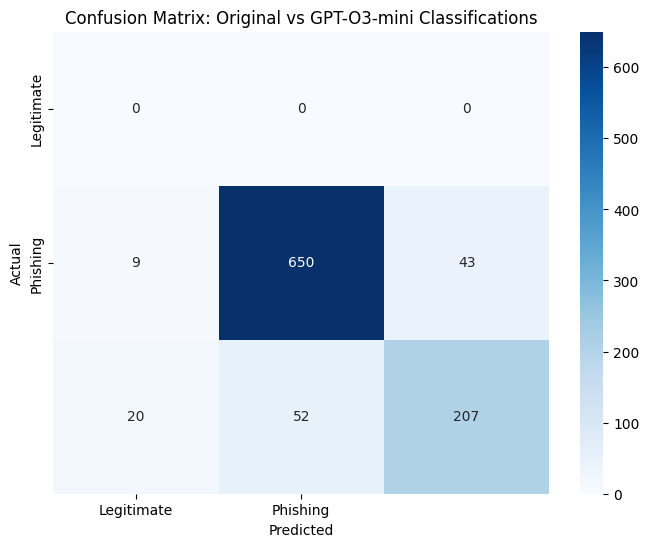

In [21]:
# Visualize confusion matrix
if enhanced_data and len(results_df) > 0:
    cm = confusion_matrix(
        results_df['original'].map({'legitimate': 0, 'phishing': 1}),
        results_df['generated'].map({'legitimate': 0, 'phishing': 1, 'unknown': -1})
    )
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    plt.title('Confusion Matrix: Original vs GPT-O3-mini Classifications')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Conclusion

### What We've Accomplished:
1. **Downloaded and Profiled** the SpamAssassin dataset directly from the source
2. **Prepared Data** in the correct JSONL format for Azure AI Foundry
3. **Created Train/Test Splits** maintaining label distribution (80/20 split)
4. **Enhanced Training Data** with GPT-O3 generated reasoning steps
5. **Validated Data Quality** to ensure high-quality training examples

### Key Takeaways:
- **Data Format**: Azure AI Foundry requires JSONL with `messages` structure containing system, user, and assistant roles
- **System Prompts**: Define the model's behavior and task clearly
- **Reasoning Steps**: Chain-of-thought reasoning can significantly improve model interpretability and performance
- **Quality Control**: Always validate generated data before training to ensure accuracy

### Next Steps:
1. Upload the prepared datasets to Azure AI Foundry
2. Configure fine-tuning parameters (learning rate, epochs, batch size)
3. Monitor training progress and evaluate model performance
4. Deploy the fine-tuned model for phishing detection
5. Test the model with real-world examples

### Files Generated:
- `spam_train_azure.jsonl`: Basic training data in Azure format - for vanilla supervised fine-tuning.
- `spam_test_azure.jsonl`: Test data in Azure format
- `spam_train_enhanced.jsonl`: Training data with reasoning steps 
- `spam_train_enhanced_filtered.jsonl`: Quality-filtered training data with reasoning - we will use it for distillation supervised fine-tuning

In [ ]:
1

In [ ]:
enhanced_data[0]['original_label']

In [ ]:
enhanced_data[0]['messages'][2]

In [ ]:
import os

# Get the value of an environment variable
variable_name = "o3-mini-key"
value = os.getenv(variable_name)

In [ ]:
value

In [ ]:
import os

# Get the value of an environment variable
variable_name = "o3-mini-key"
value = os.getenv(variable_name)
print(value)

In [ ]:
import os

for name, value in os.environ.items():
    print("{0}: {1}".format(name, value))

In [ ]:
import os

# Set environment variables
# os.environ['o3-mini-key'] = "53t09OTE4xqyj2OU9vjWaMSDYHopnWQZC1NG8bD3y2cNgZjDTc7WJQQJ99BGACfhMk5XJ3w3AAAAACOGCRpf"
os.getenv('o3-mini-key')

In [ ]:
import os
from openai import AzureOpenAI

endpoint = "https://yych-mddci70i-eastus.openai.azure.com/"
model_name = "o3-mini"
deployment = "o3-mini"

subscription_key = "959NxQWvr9R0PSNrGKHS5kNinrIQCgoZNpm7Wg7AyEAAvnpeVKkCJQQJ99BGACYeBjFXJ3w3AAAAACOGfYRA"
api_version = "2024-12-01-preview"

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=subscription_key,
)

response = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
            "role": "user",
            "content": "I am going to Paris, what should I see?",
        }
    ],
    max_completion_tokens=100000,
    model=deployment
)

print(response.choices[0].message.content)